# Walk through all steps used in research

Author: CK kibet

citation: Kibet CK and Machanick P. Transcription factor motif quality assessment requires systematic comparative analysis [version 1; referees: 2 approved with reservations]. F1000Research 2015, 4(ISCB Comm J):1429 (doi: 10.12688/f1000research.7408.1)

Feel free to email at calebkibet88@gmail.com for any clarity needed. 

#### First, lets import all the base modules

In [94]:
import os
import errno
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums

%matplotlib inline

###Convert the ENCODE data into posneg format

posneg format is a format we jsut made up to represent a file in the following format: 

    chromosome:start-end score sequence eg

    chr19:10828427-10828527	486.128011369018 TCTACTGGCACGTCTGCCTGCCAATAAGAT
    
To convert to this format, the following are required:

1. A human genome file in Hg19 format that has been repeat-masked with NNs
2. MEME fastafrombed script--jsut get compete meme tools, you'll need them later
+ A bedwidden scrpt from the folowing site.

A script to execute the whole process is provided.

#### Convert Encode to bed file

In [2]:
!cut -f1,2,3,7 ../ChIP_seq/Data/Downloaded/wgEncodeAwgTfbsBroadDnd41CtcfUniPk.narrowPeak >../ChIP_seq/Data/Derived/BroadDnd41Ctcf-tmp.bed 

####Extract the fasta files in the posneg format.

In [3]:
genome_path = 'provide path to hg19 genome'

In [4]:
import os
os.system("./bed2chipseg.sh ../ChIP_seq/Data/Derived/BroadDnd41Ctcf-tmp.bed  ../ChIP_seq/Data/Derived/BroadDnd41Ctcf %s" %genome_path)

Assuming the motifs have been generated, they can be used to score the above sequences using the following scoring functions:

    1. gomeroccupnacyscore
    2. energyscore
    3. maxoccupancyscore
    4. occupancyscore
    5. occupancyscore
    6. sumlogoddsscore
    7. maxlogoddsscore
In my case, I querried a local motf database for motifs for a given TF.

####Import the module to directly access the functions.

In [2]:
import Assess_motifsdb as assess

####Get the base directory 

In [4]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('Assess_motifsdb.py')))

For the purpose of this demo, we are going to use Ctcf motifs.

Create a results directory complete with paths using:

In [5]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [8]:
tf = 'ctcf'
results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
mkdir_p(results_path)

With the Results folder for Ctcf in place, the next this in to get a list of all the ChIP-seq data convered as shown above to posneg format. We use the function below. 

In [9]:
import glob
chip_seq_list = glob.glob('%s/ChIP_seq/Data/Derived/%s/*' % (BASE_DIR, tf))

We use gomeroccupancy score for this demo, but a quick run for all the motifs can be run by looping though all the scoring functions as follows:

In [10]:
#for key in assess.score_extensions:
    #assess.run_all(tf, key, '%s/Data/Motifs/%s.meme' %(BASE_DIR, tf), chip_seq_list, results_path)

Uncomment the above cell for a quick run of all the scoring functions. Internally, the program chooses 10 random sequences, in a situation where more than 10 are available. We observed no better discrimination from more data, just takes lots of time. 

In [11]:
key = 'gomeroccupancyscore'
assess.run_all(tf, key, '%s/Data/Motifs/%s.meme' %(BASE_DIR, tf), chip_seq_list, results_path)

###Combining the above steps to loop through multiple TFs and scoring functions

In [13]:
#tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
tf_list = ['ctcf']
for tf in tf_list:
    results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
    
    #make results path
    mkdir_p(results_path)
    
    #Exract the available ChIP-seq list
    chip_seq_list = glob.glob('%s/ChIP_seq/Data/Derived/%s/*' % (BASE_DIR, tf))
    
    test_meme_input = '%s/ChIP_seq/Data/Motifs/%s.meme' %(BASE_DIR, tf)
    
    for key in assess.score_extensions:
        assess.run_all(tf, key, test_meme_input, chip_seq_list, results_path)

##Run analysis using CentriMo

For motif enrichment analsys, a *run_centrimo* module is provided. This requires that the The MEME Suite tools version 4.10.0, which can be intsalled from <a href='http://meme-suite.org/doc/download.html?man_type=web'>MEME-Suite</a>.

The steps followed are similar as above:

In [14]:
import run_centrimo

In [15]:
tf_list = "esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
#tf_list = ['sp1']
for tf in tf_list:
    results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
    
    #make results path
    mkdir_p(results_path)
    
    #Exract the available ChIP-seq list
    chip_seq_list = glob.glob('%s/ChIP_seq/Data/Derived/%s/*' % (BASE_DIR, tf))
    
    #meme file with motifs to determine enrichment
    test_meme_input = '%s/ChIP_seq/Data/Motifs/%s.meme' %(BASE_DIR, tf)
    
    #Run the cmplete pipeline
    run_centrimo.run_centrimo(tf, chip_seq_list, test_meme_input, results_path)

## Paper figures and tables

The above steps will only get up as far as obtaining the raw initial results. The steps that follow, outlines how the data was further processed and plotted. 

In [75]:
tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()

score_key = ['energy', 'gomer','sumlog', 'sumoc','maxoc', 'ama', 'maxlog']
stat = 'spearman'
for tf in tf_list:
    results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
    raw_data = []
    raw_data.append(["Motif"])
    flag = 0
    for key in score_key:
        i = 1
        raw_data[0].append(key)
        with open('%s/%s.%s' % (results_path,tf,key)) as score_out:
            for line in score_out:
                if line.split()[1]=="AUC":
                    continue
                else:
                    if flag ==0:
                        raw_data.append([line.split()[0]])
                        raw_data[i].append(line.split()[4])
                        i+=1
                    else:
                        raw_data[i].append(line.split()[4])
                        i+=1
            flag = 1
        with open("%s/%s_%s.rawscores" %(results_path,tf, stat), 'w') as raw_out:
            for row in raw_data:
                raw_out.writelines('\t'.join(map(str, row)) + '\n')

####MOTIF INFORMATION CONTENT AND LENGTH

Summarize the motifs' information content, length as well as their scores. This is used to determine the level of correlation between the motif chracter and the scores asigned. This helps understand how IC and motif length affect the score asigned by various scores.

In [25]:
#!/usr/bin/python
from __future__ import print_function
import sys
from math import log
import os

def mot_summary(motif_file, raw_scores, out_file):
    '''
    Summary of motif and score
    '''
    found = 0
    row = 0
    n_rows = 0
    entropy = 0
    total_entropy = 0
    motifs = 0
    name = ""
    raw_dict = {}
    with open(out_file, "w") as write_out:

        with open(raw_scores) as raw_in:
            for line in raw_in:
                raw_dict[line.split()[0]] = line.split()[1:]
        out = "Motif_name\tMotif_IC\tAverage_IC\tMotif_length\t%s\t%s\t%s\t%s\n" % \
              (raw_dict["Motif"][0], raw_dict["Motif"][1], raw_dict["Motif"][2], raw_dict["Motif"][3])

        write_out.write(out)
        with open(motif_file, "r") as motif_file:
            for line in motif_file:
                words = line.split()
                if found == 0:
                    if line.startswith("MOTIF"):
                        # allow for motifs without an alternative name
                        if len(words) < 3:
                            words.append("")
                        name = (words[1])
                        found = 1
                        motifs += motifs
                        entropy = 0
                        continue
                if found == 1:
                    if line.startswith("letter-probability"):
                        n_rows = int((line.split("w="))[1].split()[0])
                        found = 2
                    continue
                if found == 2:
                    if line == "\n":
                        continue
                    else:
                        check = 0
                    for val in words:
                        if float(val) > 0:
                            check += float(val) * log(float(val))/log(2.0)
                            entropy += float(val) * log(float(val))/log(2.0)
                    row += 1
                    if row >= n_rows:
                        v = 2*n_rows+entropy
                        out = '%s\t%f\t%f\t%i\t%f\t%f\t%f\t%f\n'\
                              % (name, v, (v/n_rows), n_rows, float(raw_dict[name][0]), float(raw_dict[name][1]),
                                 float(raw_dict[name][2]), float(raw_dict[name][3]))
                        write_out.write(out)
                        #n+= 1
                        #print(n)
                        found = 0
                        row = 0
                        total_entropy += (v/n_rows)

In [29]:
statistics = ['auc','mncp']
tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
for stat in statistics:
    for tf in tf_list:
        meme_file = '%s/Motifs/%s.meme' %(BASE_DIR, tf)
        results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
        test = mot_summary(meme_file,"%s/%s_%s.rawscores" % (results_path, tf, stat), "%s/%s_%s_score_ic.txt" % (results_path, tf, stat))

In [19]:
tf = 'ctcf'
results_path = '%s/Results/%s' % (BASE_DIR, tf)


#Code to reproduce figures used in the paper

###Figure1_Timelines

In [191]:
class Caption():
    def __init__(self,s):
        self.s = s
    def _repr_html_(self):
        return '<center>{0}</center>'.format(self.s)
    def _repr_latex_(self):
        return '\\begin{center}\n'+self.s+'\n\\end{center}'

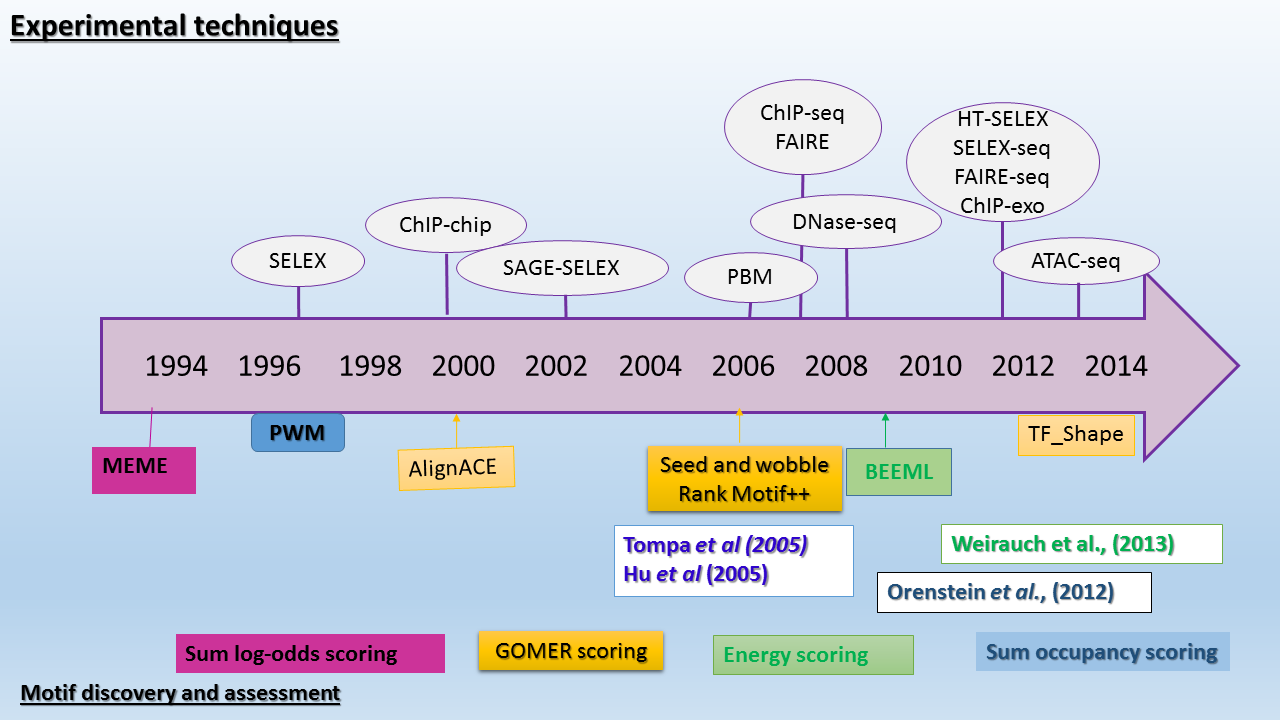

<__main__.Caption instance at 0x7f99097f2fc8>

In [213]:
from IPython.display import Image, display
test_display = """Figure 1: Evolution of motif scoring functions with experimental techniques and algorithms""" 
display(Image(filename='../Figures/Figure1_Timelines.png', embed=True, width=900), Caption(test_display))

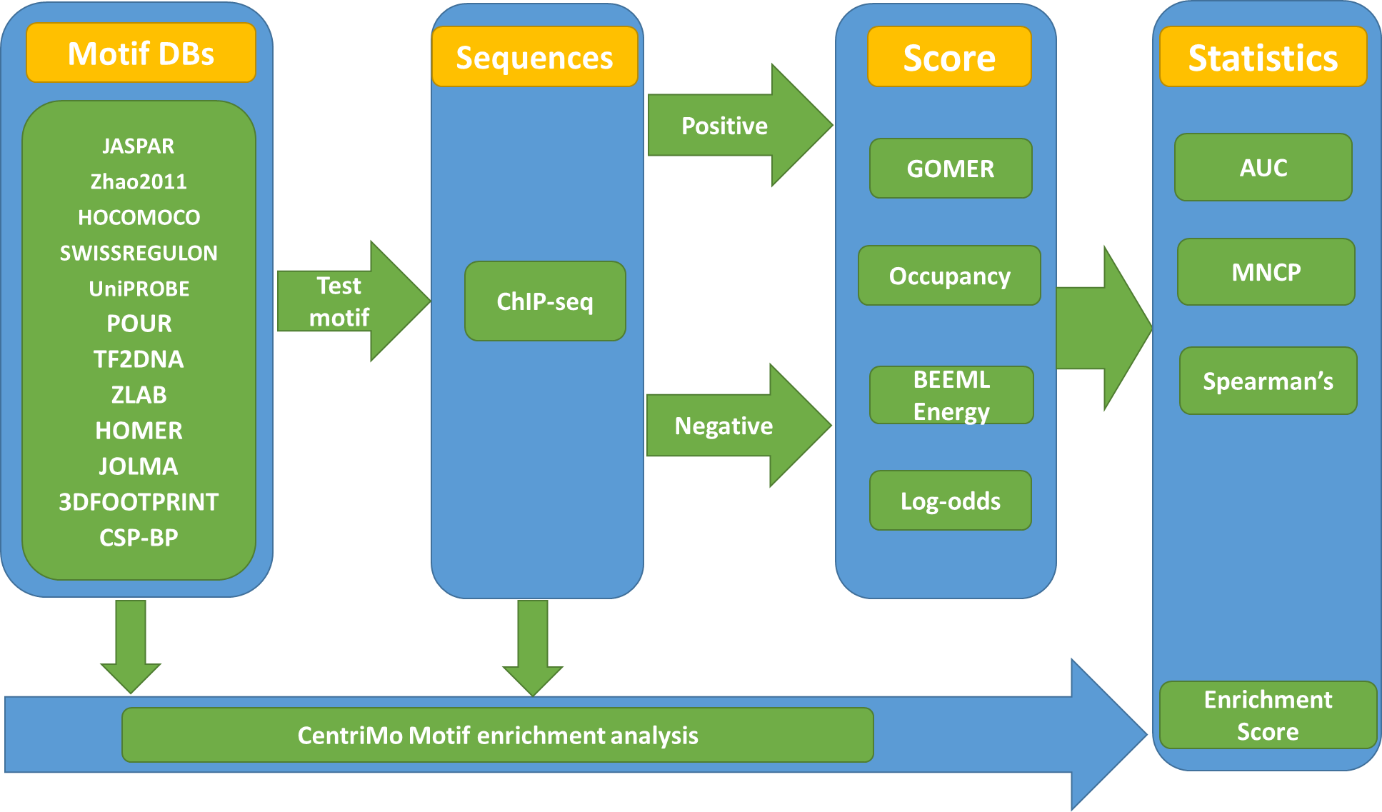

In [21]:
from IPython.display import Image
Image(filename='../Figures/Figure2_Methodology.png', embed=True, width=900) 

###Figure3_sequence_length

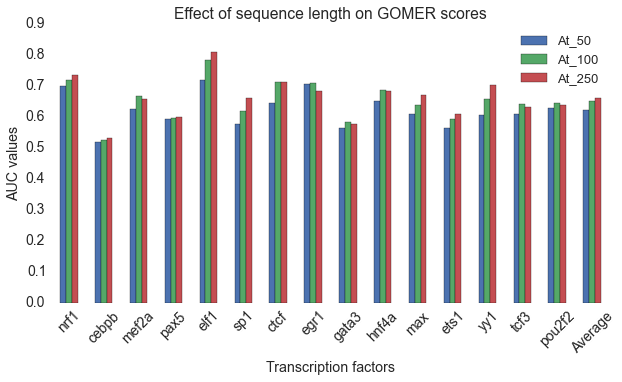

In [20]:
tf_list = ['nrf1', 'cebpb', 'mef2a', 'pax5', 'elf1','sp1','ctcf', "egr1",
           "gata3", "hnf4a", "max", "ets1", 'yy1', 'tcf3', 'pou2f2']
Av_scores = pd.DataFrame(columns=["At_50","At_100","At_250"] )
for tf in tf_list:
    raw_scores = pd.read_table('../ChIP_seq/Results/%s/%s_auc.len' %(tf,tf), header=0, index_col="Motif")

    test = raw_scores.mean().T
    
    con = test.to_frame(name=tf).T
    
    Av_scores = Av_scores.append(con)
av = Av_scores.mean(axis=0)
con = av.to_frame(name='Average').T
Av_scores = Av_scores.append(con).T

ax =Av_scores.T.plot(kind='bar', figsize=(10,5),
                     title="Effect of sequence length on GOMER scores", fontsize=14, rot=45)
ax.grid(False)
ax.set_xlabel("Transcription factors")
ax.set_ylabel("AUC values")
ax.set_axis_bgcolor('w')
fig = ax.get_figure()
fig.savefig('../Figures/Figure3_sequence_length.pdf')

####Computing significance in the difference among the sequence lengths. 

In [24]:
for seq_len1 in ["At_50","At_100","At_250"]:
    for seq_len2 in ["At_50","At_100","At_250"]:
        print seq_len1, seq_len2
        print ranksums(Av_scores.T[seq_len1],Av_scores.T[seq_len2])[1]

At_50 At_50
1.0
At_50 At_100
0.113436380836
At_50 At_250
0.0545887955048
At_100 At_50
0.113436380836
At_100 At_100
1.0
At_100 At_250
0.678450783738
At_250 At_50
0.0545887955048
At_250 At_100
0.678450783738
At_250 At_250
1.0


###Figure4_cell_line_specific

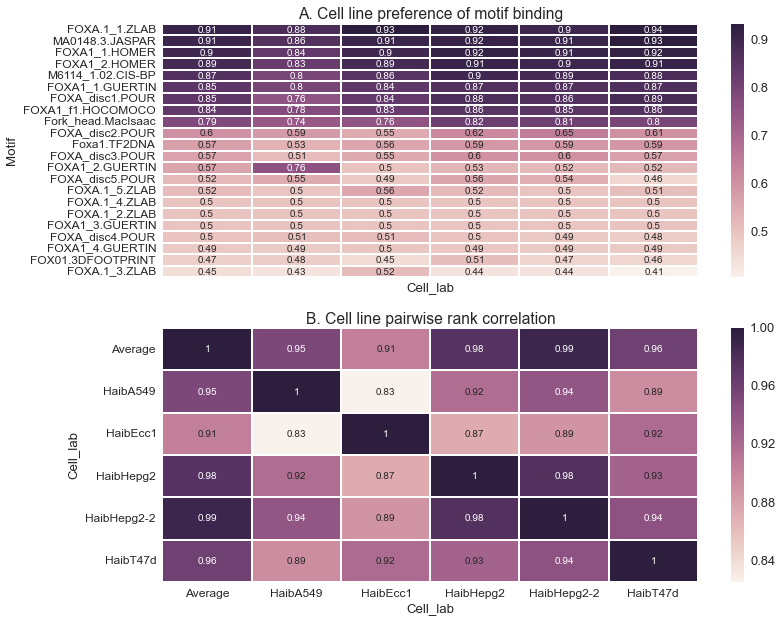

In [19]:
def plot_raw_assess(raw_data, figure_output, stat):
    """
    This function allows the raw data to be plotted  in the form of a heatmap.
    
    This way, information about how each motif scores in different cell lines is
    obtained
    """
    #Increase the font
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, sharey=False)
    sns.set(font_scale=1.3)
    #sns.set_style("white")
    raw_max = pd.read_table(raw_data)
    raw_max = raw_max.drop_duplicates()
    
    raw_edit = raw_max.pivot('Motif', 'Cell_lab', stat)
    raw_edit.sort(columns="Average", axis=0, ascending=False, inplace=True)
    #fig, ax = plt.subplots()
    ax1.set_title('A. Cell line preference of motif binding')
    ax2.set_title('B. Cell line pairwise rank correlation')
    # the size of A4 paper
    #fig.set_size_inches(11, 8)
    sns.heatmap(raw_edit, annot=True, ax = ax1)
    sns.heatmap(raw_edit.corr(method='spearman'), ax = ax2, annot=True)
    f = plt.gcf()
    f.savefig(figure_output, bbox_inches='tight')
    return raw_edit

raw_edit = plot_raw_assess("../ChIP_seq/Results/foxa/foxa_raw.gomer", 
                           '../Figures/Figure4_cell_line_specific_gomer.pdf', 'AUC')

##Figure 5...Effect of statistics on motif ranking

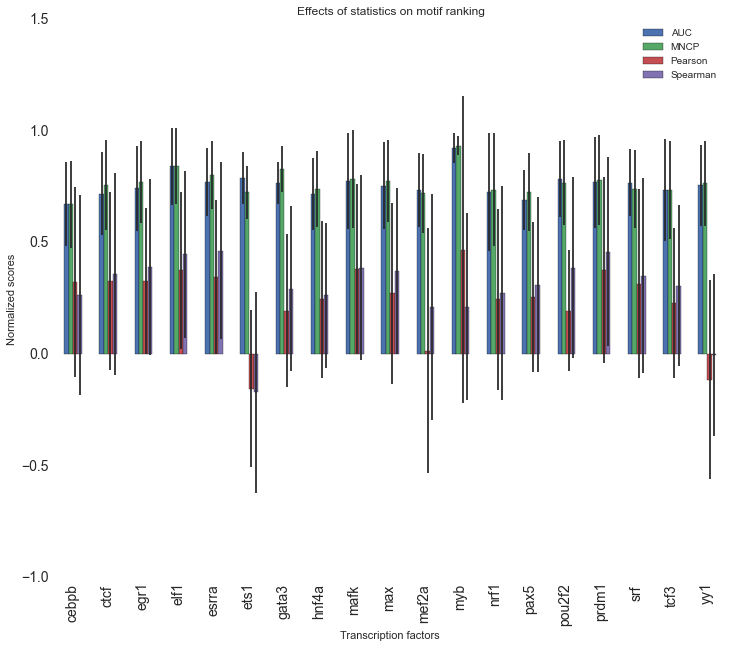

In [86]:

score = 'gomer'
tf_list = "ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 srf tcf3 yy1".split()

tf = 'cebpb'
chip = pd.read_table('../ChIP_seq/Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
chip = chip/chip.max()
chip_std = chip.std().to_frame(name=tf).T
chip_mean = np.mean(chip).to_frame(name=tf)
chip_mean_test = chip_mean.T
rank_sum = ranksums(chip['AUC'],chip['Spearman'])[1] # compute wilcoxon rank-sum test

for tf in tf_list:
    chip = pd.read_table('../ChIP_seq/Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
    chip = chip/chip.max()
    #print tf
    rank_sum += ranksums(chip['AUC'],chip['Spearman'])[1]
    chip_s = chip.std().to_frame(name=tf)
    chip_std = chip_std.append(chip_s.T)
    chip_mean = np.mean(chip).to_frame(name=tf)
    
    chip_mean_test = chip_mean_test.append(chip_mean.T)
ax = chip_mean_test.plot(kind='bar',yerr=chip_std, figsize=(12,10),
                         title="Effects of statistics on motif ranking", fontsize=14)
#ax.grid(False)
ax.set_xlabel("Transcription factors")
ax.set_ylabel("Normalized scores")
ax.set_axis_bgcolor('W')
fig = ax.get_figure()

#fig.savefig('../Figures/Figure5_score_and_statistic_new.pdf')


In [87]:
rank_sum/20

0.002231100386339958

In the figure above the spread of the scores depending on the statistic, as measured by the eror bars, shows how unreliable the use of correlation statistics to rank the motfs would be.

##Figure 6: Effect of the choice of negative sequence on motif scoring

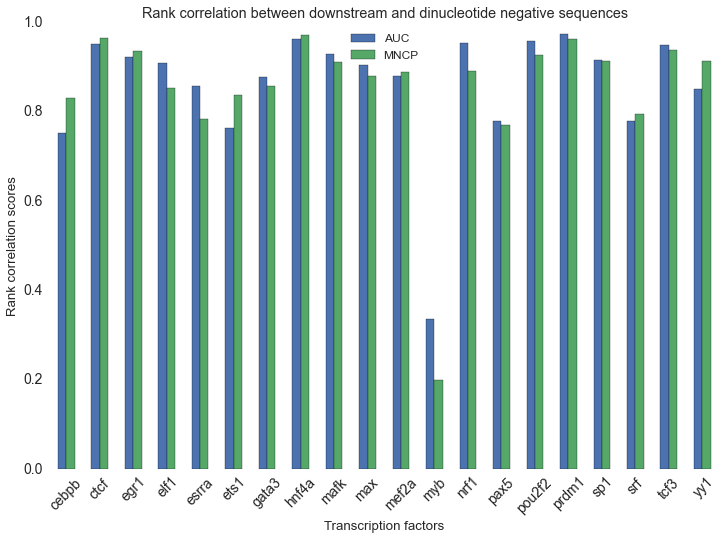

In [92]:

tf_list = "ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
score = 'gomer'
tf = 'cebpb'
chip = pd.read_table('%s/ChIP_seq/Results/%s/%s.%s' 
                     % (BASE_DIR, tf, tf, score), index_col='Motif')
dinuc = pd.read_table('%s/Dinuc_shuffled/Results/%s/%s.%s' % (BASE_DIR, tf.capitalize(), tf, score), index_col='Motif')

ran_corr = ranksums(chip['MNCP'], dinuc['MNCP'])[1] #Determine how significantly different the scores are
chip_rank = chip.rank(ascending=False)
dinuc_rank = dinuc.rank(ascending=False)
chip = chip/chip.max()
chip_mean = np.mean(chip).to_frame(name=tf)
chip_mean_test = chip_mean.T

a = dinuc_rank.corrwith(chip_rank)
a = a.to_frame(name=tf).T
for tf in tf_list:
    chip = pd.read_table('%s/ChIP_seq/Results/%s/%s.%s'
                         % (BASE_DIR, tf, tf, score), index_col='Motif')
    dinuc = pd.read_table('%s/Dinuc_shuffled/Results/%s/%s.%s' 
                          % (BASE_DIR, tf.capitalize(), tf, score), index_col='Motif')
    ran_corr += ranksums(chip['MNCP'], dinuc['MNCP'])[1]
    chip = chip/chip.max()
    chip_mean = np.mean(chip).to_frame(name=tf)

    dinuc = dinuc/dinuc.max()
    
    chip_rank = chip.rank(ascending=False)
    dinuc_rank = dinuc.rank(ascending=False)
    b = dinuc_rank.corrwith(chip_rank)
    b = b.to_frame(name=tf).T
    a = a.append(b)
    chip_mean_test = chip_mean_test.append(chip_mean.T)
#chip_mean_test.plot(kind='bar', figsize=(10,10), title="Effects of statistics on motif ranking", fontsize=14, rot=45)
del a['Spearman']
del a['Pearson']
ax = a.plot(kind='bar', figsize=(12,8),
            title="Rank correlation between downstream and dinucleotide negative sequences", fontsize=14, rot=45)
ax.set_xlabel("Transcription factors")
ax.set_ylabel("Rank correlation scores")
ax.set_axis_bgcolor('W')
fig = ax.get_figure()
fig.savefig('../Figures/Figure10_effect_negative_sequences.pdf', bbox_inches='tight')

We observe the choice of negative sequences to have little effect on the ranks assigned to the motifs. In the figure above, we computed and plotted the rank correlation of scores normalized by maximum score for each TF. However some TFs seem to be affected most by this. This generally seems to affect motifs with indirect (Myb) of flanking site binding (Tcf3)

In [93]:
auc =ran_corr/20
auc =(0.45913029381266385 + 0.50887947936999434)/2

###Figure7_effect_of_scoring_auc

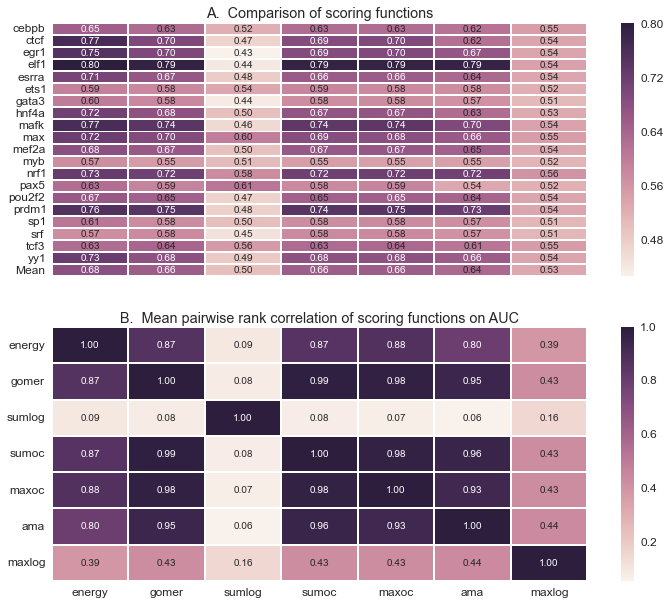

In [17]:
stat='auc'
tf_list="cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
#tf_list = "esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()
#fig, ax = plt.subplots()
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, sharey=False)
#sns.set(font_scale=1.2)

#fig.set_size_inches(10, 8)

scores = "energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum, annot=True, ax=ax1, fmt='.2f')
ax1.set_title("A.  Comparison of scoring functions")



tf = 'ctcf'
stat = 'auc'
mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))

tf_list ="cebpb egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
#tf_list = "gata3 hnf4a mafk max myb pou2f2 tcf3".split()
for tf in tf_list:
    mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a/20, annot=True, ax=ax2, fmt='.2f')
ax2.set_title("B.  Mean pairwise rank correlation of scoring functions on AUC")
f=plt.gcf()
#f.savefig('../Figures/Figure6_effect_of_scoring_auc_new.pdf', bbox_inches='tight')

####Table S1: Determine the significance of the difference between the AUC values of the various scoring functions using Wilcoxon rank-sum statistic 

**NB**: This should only be run after the above section to generate the score_sum dataframe

In [29]:
scores = "energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()
ans = []
#ans.append(scores)
i = 0
for score1 in scores:
    ans.append([score1])
    for score2 in scores:
        ans[i].append(ranksums(score_sum[score1],score_sum[score2])[1])
    i+=1
scores = "Scoring_function energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()
pvalues = pd.DataFrame(ans, columns=scores)     

#Save to csv file
pvalues.to_csv('../Supplementary_Tables/Table_S1.csv')

###Figure8_effect_of_scoring_mncp

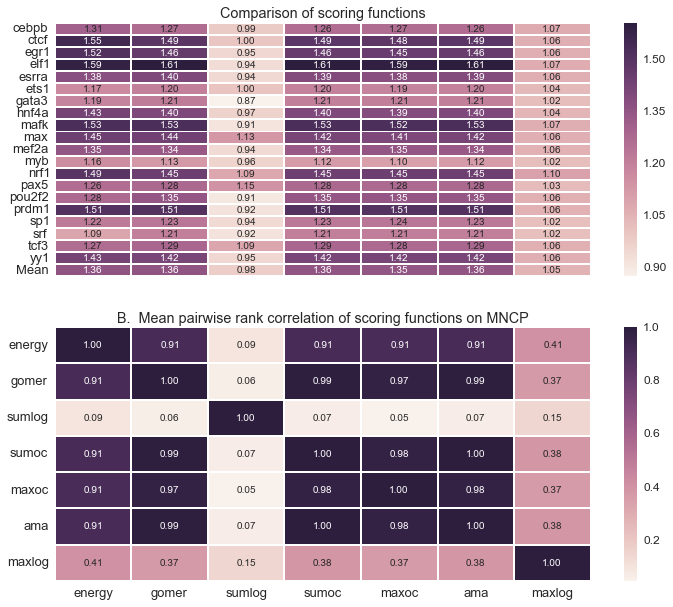

In [13]:
stat='mncp'
tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, sharey=False)
#fig, ax = plt.subplots()

sns.set(font_scale=1.2)

#fig.set_size_inches(10, 8)

scores = "energy	gomer	sumlog	sumoc	maxoc  ama	maxlog".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum, annot=True, ax=ax1, fmt='.2f')
ax1.set_title("Comparison of scoring functions")

tf = 'ctcf'
stat = 'mncp'
mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))

tf_list = "cebpb egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
for tf in tf_list:
    mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a/20, annot=True, ax=ax2, fmt='.2f')
ax2.set_title("B.  Mean pairwise rank correlation of scoring functions on MNCP")
#f=plt.gcf()
#f.savefig('../Figures/Figure6_effect_of_scoring_auc.pdf', bbox_inches='tight')
f=plt.gcf()
f.savefig('../Figures/Figure7_effect_of_scoring_mncp_new.pdf', bbox_inches='tight')

####Table S2: Determine the significance of the difference between the MNCP values of the various scoring functions using Wilcoxon rank-sum statistic 

**NB**: This should only be run after the above section to generate the score_sum dataframe

In [31]:
from scipy.stats import ranksums
scores = "energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()
ans = []
#ans.append(scores)
i = 0
for score1 in scores:
    ans.append([score1])
    for score2 in scores:
        ans[i].append(ranksums(score_sum[score1],score_sum[score2])[1])
    i+=1
scores = "Scoring_function energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()
pvalues = pd.DataFrame(ans, columns=scores)     

#Save to csv file
pvalues.to_csv('../Supplementary_Tables/Table_S2.csv')

###Figure9_motif_length_ic_effect

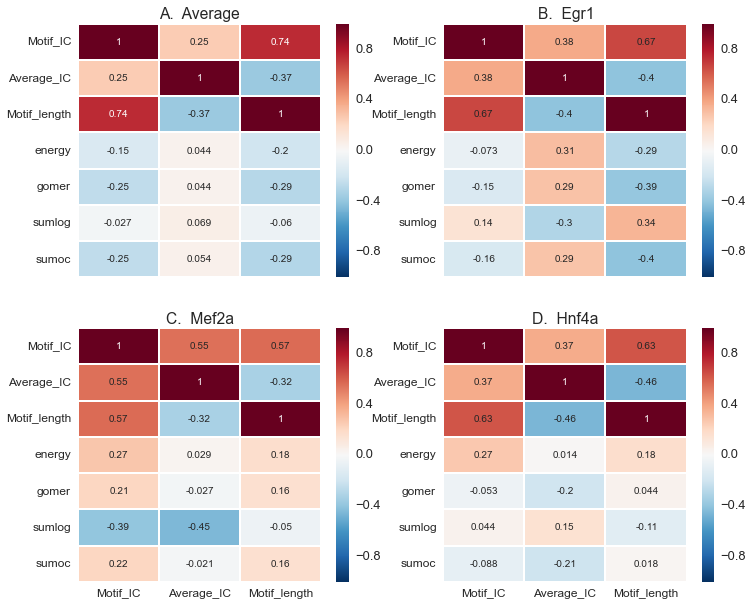

In [74]:
tf ='egr1' #initialize
stat = 'auc'
tf_list = "cebpb ctcf elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()

tf_path = "%s/ChIP_seq/Results/%s" % (BASE_DIR,tf)
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
score_ic = df.corr()

for tf in tf_list:
    tf_path = "%s/ChIP_seq/Results/%s" % (BASE_DIR,tf)
    #df = tf+"_df"
    df1 = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf,stat), index_col="Motif_name")
    score_ic2 = df1.corr()
    score_ic = score_ic.add(score_ic2, fill_value=0)
test = score_ic/(len(tf_list)+1)

del test['energy']
del test['gomer']
del test['sumlog']
del test['sumoc']

test = test


path = "%s/ChIP_seq/Results" % BASE_DIR

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=False)
sns.set(font_scale=1.3)
sns.heatmap(test, annot=True, ax = ax1)
ax1.set_title("A.  Average")

tf = "egr1"
tf_path = "%s/%s" % (path, tf)
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df

sns.heatmap(df, annot=True, ax = ax2)
ax2.set_title('B.  '+tf.capitalize())

tf = "mef2a"
tf_path = "%s/%s" % (path, tf)
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df

sns.heatmap(df, annot=True, ax = ax3)
ax3.set_title('C.  '+tf.capitalize())

tf = "hnf4a"
tf_path = "%s/%s" % (path, tf)
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df
sns.heatmap(df, annot=True, ax = ax4)
ax4.set_title('D.  '+tf.capitalize())

f.savefig('../Figures/Figure8_motif_length_ic_effect_minimal.pdf', bbox_inches='tight')

###Figure10_motif_database_ranks

The best perofmeing motif from each database is extraced using the script below

In [42]:
tf_list=["gata3", "egr1", "hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']

selected_col =['JASPAR', 'HOCOMOCO',  'HOMER', 'POUR', 'JOLMA', 'GUERTIN', 'ZLAB', 'TF2DNA', 'SWISSREGULON', 'CIS-BP']
for score in ('energy','gomer', 'ama','sumlog', 'maxoc', 'sumoc'):
    for stat in ('mncp','auc'):
        stat_dict= {'auc':1, "mncp":2}
        #tf_list=["gata3", "hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1', 'egr1']


        cent_out = []
        cols = 0
        i=1
        cent_out.append(["Motif"])
        for tf in tf_list:
            cent_out.append([tf])
            for col in selected_col:
                if cols ==0:
                    cent_out[0].append(col)
                with open("../ChIP_seq/Results/%s/%s.%s" % (tf,tf, score)) as cent:
                    flag =0
                    for line in cent:
                        if flag==0:
                            if col in line:
                                cent_out[i].append(line.split()[stat_dict[stat]])
                                flag = 1
                    if flag ==0:
                        cent_out[i].append("")
            i+=1
            cols = 1
        with open('../ChIP_seq/Results/Db_ranks_%s_%s.txt' % (score,stat), 'w') as raw_out:
            for row in cent_out:
                raw_out.writelines('\t'.join(map(str, row)) + '\n')
    

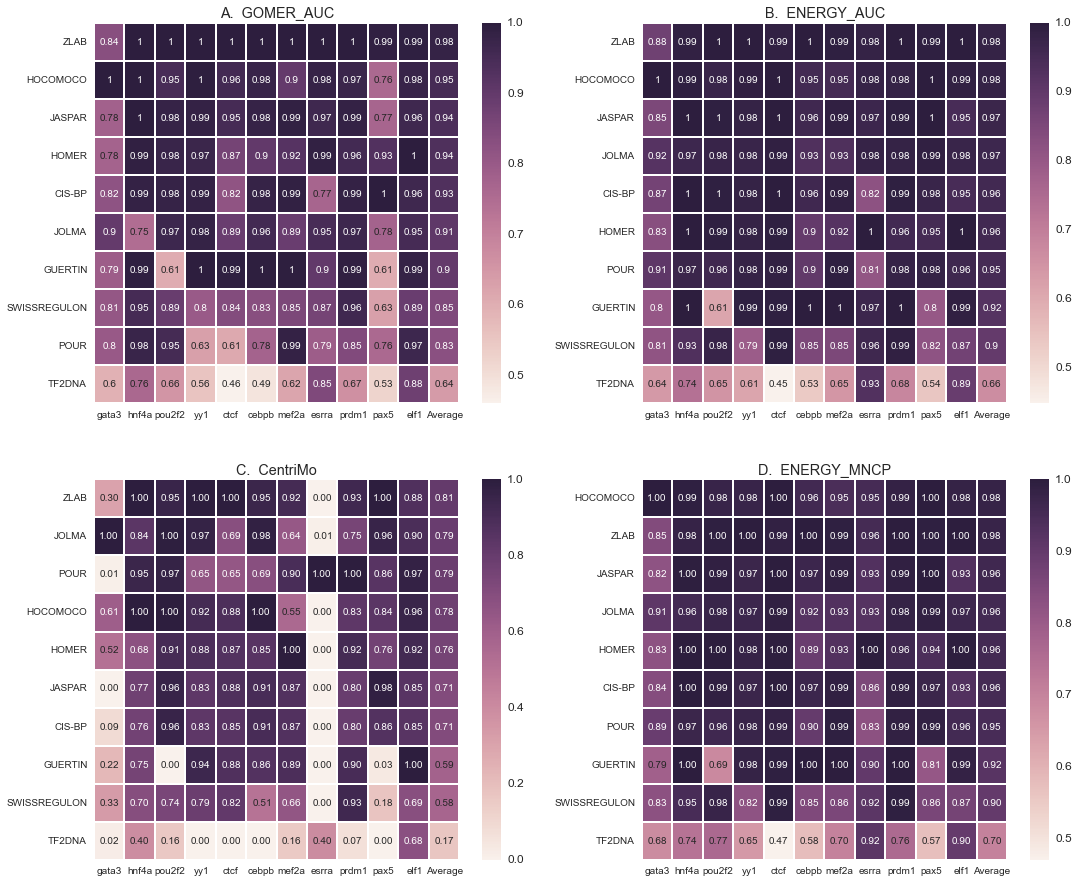

In [6]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 15), sharex=False, sharey=False)
i=1
sns.set(font_scale=1.2)
stat = 'auc'
score = 'gomer'
axi="ax"+str(i)
cent_col = pd.read_table('../ChIP_seq/Results/Db_ranks_%s_%s.txt' % (score, stat), index_col="Motif")
tf_list = "esrra hnf4a pou2f2 ".split()
tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T

new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi))
eval(axi).set_title('A.  '+score.upper()+"_"+stat.upper())
i+=1
#f.savefig('MATOM/static/files/Db_ranks_%s_%s.png' % (score, stat), bbox_inches='tight')

stat = 'auc'
score = 'energy'
axi="ax"+str(i)
cent_col = pd.read_table('../ChIP_seq/Results/Db_ranks_%s_%s.txt' % (score, stat), index_col="Motif")

#tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T

new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi))
eval(axi).set_title('B.  '+score.upper()+"_"+stat.upper())
i+=1
#f.savefig('MATOM/static/files/Db_ranks_%s_%s.png' % (score, stat), bbox_inches='tight')

axi="ax"+str(i)
cent_col = pd.read_table('../ChIP_seq/Results/Centrimo_collection.txt', index_col="Motif")


#tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T


new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi), fmt='.2f')
eval(axi).set_title('C.  CentriMo')
i+=1


stat = 'mncp'
score = 'energy'
axi="ax"+str(i)
cent_col = pd.read_table('../ChIP_seq/Results/Db_ranks_%s_%s.txt' % (score, stat), index_col="Motif")

#tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T

new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi), fmt='.2f')
eval(axi).set_title('D.  '+score.upper()+"_"+stat.upper())

#f.savefig('../Figures/Figure9_motif_database_ranks_normalized.pdf', bbox_inches='tight')

###Re-creation of the figure using Di-nucleaotide shuffle sequences scores

#Effect of scoring functions

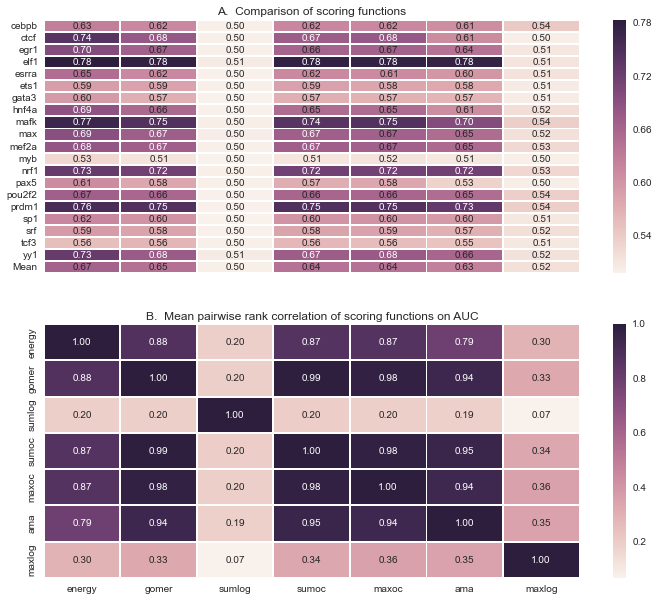

In [88]:
stat='auc'
tf_list="cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
#tf_list = "esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()
#fig, ax = plt.subplots()
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, sharey=False)
#sns.set(font_scale=1.2)

#fig.set_size_inches(10, 8)

scores = "energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    mot_score =pd.read_table("../Dinuc_shuffled/Results/%s/%s_%s.rawscores" % (tf.capitalize(),tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum, annot=True, ax=ax1, fmt='.2f')
ax1.set_title("A.  Comparison of scoring functions")



tf = 'ctcf'
stat = 'auc'
mot_score =pd.read_table("../Dinuc_shuffled/Results/%s/%s_%s.rawscores" % (tf.capitalize(),tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))

tf_list ="cebpb egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
#tf_list = "gata3 hnf4a mafk max myb pou2f2 tcf3".split()
for tf in tf_list:
    mot_score =pd.read_table("../Dinuc_shuffled/Results/%s/%s_%s.rawscores" % (tf.capitalize(),tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a/20, annot=True, ax=ax2, fmt='.2f')
ax2.set_title("B.  Mean pairwise rank correlation of scoring functions on AUC")
f=plt.gcf()
#f.savefig('../Figures/Figure6_effect_of_scoring_auc_new.pdf', bbox_inches='tight')

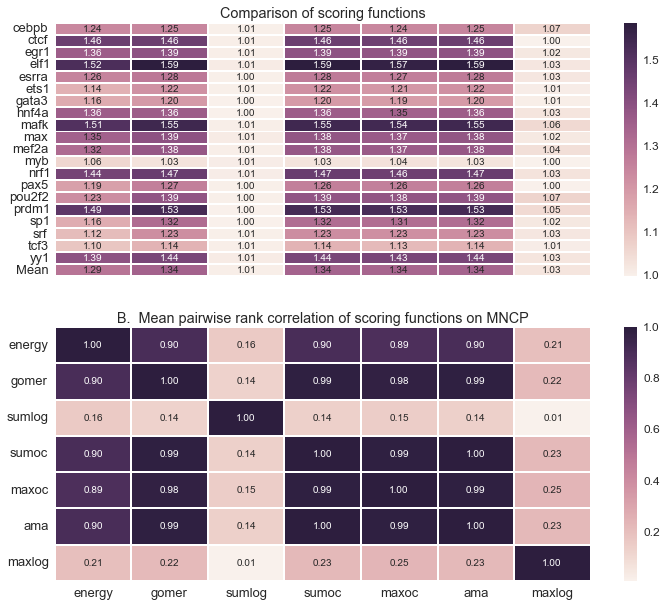

In [90]:
stat='mncp'
tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, sharey=False)
#fig, ax = plt.subplots()

sns.set(font_scale=1.2)

#fig.set_size_inches(10, 8)

scores = "energy	gomer	sumlog	sumoc	maxoc  ama	maxlog".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    mot_score =pd.read_table("../Dinuc_shuffled/Results/%s/%s_%s.rawscores" % (tf.capitalize(),tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum, annot=True, ax=ax1, fmt='.2f')
ax1.set_title("Comparison of scoring functions")

tf = 'ctcf'
stat = 'mncp'
mot_score =pd.read_table("../Dinuc_shuffled/Results/%s/%s_%s.rawscores" % (tf.capitalize(),tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))

tf_list = "cebpb egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
for tf in tf_list:
    mot_score =pd.read_table("../Dinuc_shuffled/Results/%s/%s_%s.rawscores" % (tf.capitalize(),tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a/20, annot=True, ax=ax2, fmt='.2f')
ax2.set_title("B.  Mean pairwise rank correlation of scoring functions on MNCP")
#f=plt.gcf()
#f.savefig('../Figures/Figure6_effect_of_scoring_auc.pdf', bbox_inches='tight')
f=plt.gcf()
#f.savefig('../Figures/Figure7_effect_of_scoring_mncp_new.pdf', bbox_inches='tight')

##Correlating motif characteristics with scores

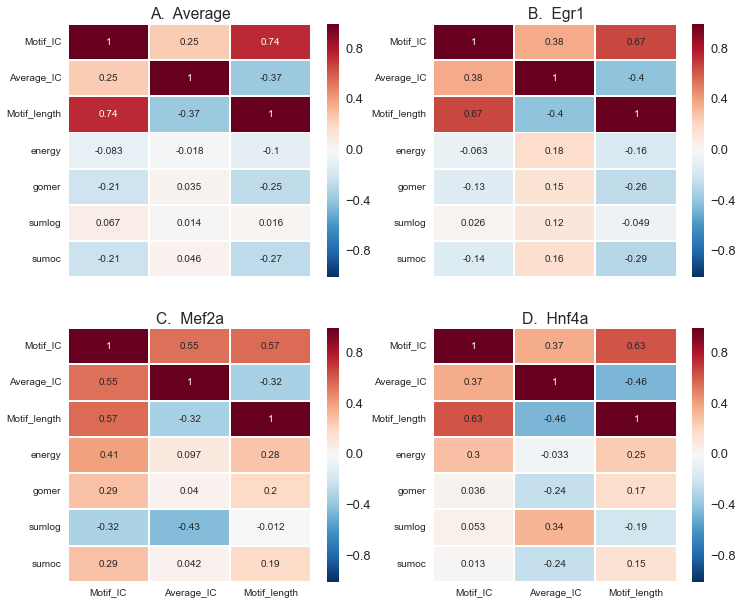

In [89]:
tf ='egr1' #initialize
stat = 'auc'
tf_list = "cebpb ctcf elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()

tf_path = "%s/Dinuc_shuffled/Results/%s" % (BASE_DIR,tf.capitalize())
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
score_ic = df.corr()

for tf in tf_list:
    tf_path = "%s/Dinuc_shuffled/Results/%s" % (BASE_DIR,tf.capitalize())
    #df = tf+"_df"
    df1 = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf,stat), index_col="Motif_name")
    score_ic2 = df1.corr()
    score_ic = score_ic.add(score_ic2, fill_value=0)
test = score_ic/(len(tf_list)+1)

del test['energy']
del test['gomer']
del test['sumlog']
del test['sumoc']

test = test

path = "%s/Dinuc_shuffled/Results" % BASE_DIR

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=False)
sns.set(font_scale=1.3)
sns.heatmap(test, annot=True, ax = ax1)
ax1.set_title("A.  Average")

tf = "egr1"
tf_path = "%s/%s" % (path, tf.capitalize())
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df

sns.heatmap(df, annot=True, ax = ax2)
ax2.set_title('B.  '+tf.capitalize())

tf = "mef2a"
tf_path = "%s/%s" % (path, tf.capitalize())
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df

sns.heatmap(df, annot=True, ax = ax3)
ax3.set_title('C.  '+tf.capitalize())

tf = "hnf4a"
tf_path = "%s/%s" % (path, tf.capitalize())
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df
sns.heatmap(df, annot=True, ax = ax4)
ax4.set_title('D.  '+tf.capitalize())

#f.savefig('../Figures/Figure8_motif_length_ic_effect_minimal.pdf', bbox_inches='tight')

##Ranks of motif databases 

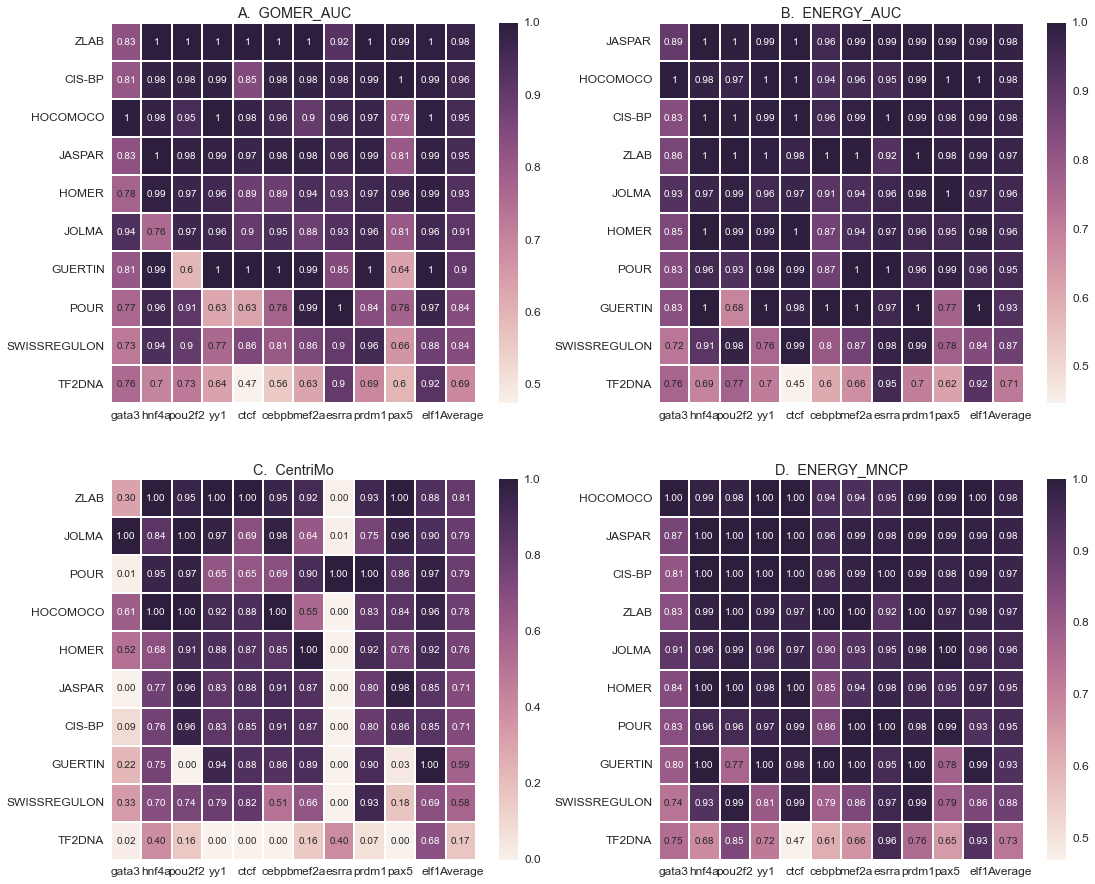

In [91]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 15), sharex=False, sharey=False)
i=1
sns.set(font_scale=1.2)
stat = 'auc'
score = 'gomer'
axi="ax"+str(i)
cent_col = pd.read_table('../Dinuc_shuffled/Results/Db_ranks_%s_%s.txt' % (score, stat), index_col="Motif")
tf_list = "esrra hnf4a pou2f2 ".split()
tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T

new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi))
eval(axi).set_title('A.  '+score.upper()+"_"+stat.upper())
i+=1
#f.savefig('MATOM/static/files/Db_ranks_%s_%s.png' % (score, stat), bbox_inches='tight')

stat = 'auc'
score = 'energy'
axi="ax"+str(i)
cent_col = pd.read_table('../Dinuc_shuffled/Results/Db_ranks_%s_%s.txt' % (score, stat), index_col="Motif")

#tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T

new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi))
eval(axi).set_title('B.  '+score.upper()+"_"+stat.upper())
i+=1
#f.savefig('MATOM/static/files/Db_ranks_%s_%s.png' % (score, stat), bbox_inches='tight')

axi="ax"+str(i)
cent_col = pd.read_table('../ChIP_seq/Results/Centrimo_collection.txt', index_col="Motif")


#tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T


new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi), fmt='.2f')
eval(axi).set_title('C.  CentriMo')
i+=1


stat = 'mncp'
score = 'energy'
axi="ax"+str(i)
cent_col = pd.read_table('../Dinuc_shuffled/Results/Db_ranks_%s_%s.txt' % (score, stat), index_col="Motif")

#tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T

new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi), fmt='.2f')
eval(axi).set_title('D.  '+score.upper()+"_"+stat.upper())

#f.savefig('../Figures/Figure9_motif_database_ranks_normalized.pdf', bbox_inches='tight')